# Linear Regression from scratch
In this project I will be implementing a non-vectorized and vectorized version of simple Linear Regression using Gradient Descent. 

## Data Preparation
Before creating the linear regression models, we first need to prepare the training data.

As the focus of this project is implementation, not impactful real-world results, we will use the California housing price dataset included in the sklearn library, as it doesn't require significant preprocessing.

Let's begin by looking at some of the entries to get an idea of how the dataset is structured.

In [94]:
from sklearn.datasets import fetch_california_housing
import numpy as np

data = fetch_california_housing()

print(data.feature_names, data.target_names, end="\n\n")

for i in range(5):
    print(list(round(float(j), 3) for j in list(data.data[i])), data.target[i])

print(f"\nNumber of missing values in training data: {np.sum(np.isnan(data.data)) + np.sum(np.isnan(data.target))}")

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'] ['MedHouseVal']

[8.325, 41.0, 6.984, 1.024, 322.0, 2.556, 37.88, -122.23] 4.526
[8.301, 21.0, 6.238, 0.972, 2401.0, 2.11, 37.86, -122.22] 3.585
[7.257, 52.0, 8.288, 1.073, 496.0, 2.802, 37.85, -122.24] 3.521
[5.643, 52.0, 5.817, 1.073, 558.0, 2.548, 37.85, -122.25] 3.413
[3.846, 52.0, 6.282, 1.081, 565.0, 2.181, 37.85, -122.25] 3.422

Number of missing values in training data: 0


Now, we'll normalize the data by scaling it down and centering it around 0.

In [95]:
X_raw = data.data # get features
y_raw = data.target # get target

mean = np.mean(X_raw, axis=0)
std = np.std(X_raw, axis=0)

X_norm = (X_raw - mean) / std # center around 0 and scale down

Then we'll shuffle it.

In [96]:
num_samples = X_norm.shape[0] # get number of samples in X

rng = np.random.default_rng(seed=101) # create seeded random number generator for reproducability
permutation = rng.permutation(num_samples) # get array of integers up to number of samples in X in random order for shuffling

X_shuf = X_norm[permutation] # reordering using np indexing
y_shuf = y_raw[permutation] # reordering using np indexing

And finally split the dataset into train, validation, and test sets, where 70% of our data is used for training and 15% for validation and testing, respectively.

In [97]:
train_end = int(0.7 * num_samples)
val_end = train_end + int(0.15 * num_samples)

X_train = X_shuf[:train_end]
y_train = y_shuf[:train_end]

X_val = X_shuf[train_end:val_end]
y_val = y_shuf[train_end:val_end]

X_test = X_shuf[val_end:]
y_test = y_shuf[val_end:]

## Implementation
We will now implement the linear regression models, starting with the non-vectorized approach.

### Non-Vectorized

In [98]:
class LinearRegressionNonVectorized():
    """Class bundling all functions for non-vectorized linear regression"""

    def __init__(self, X_train:np.ndarray, y_train:np.ndarray, batch_size:int, learning_rate:float):
        """Initialize training parameters as well as weights and bias"""

        self.weights = None
        self.bias = None

        self.X_train = X_train
        self.y_train = y_train

        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_features = len(X_train[0])
        self.num_batches = (len(X_train) // self.batch_size) + 1 if (len(X_train) % self.batch_size != 0) else len(X_train) // self.batch_size

        self.loss_history = []

        self.init_weights()

    def init_weights(self):
        """Initialize the weights and bias of the model by uniformly sampling from values between -1 and 1"""

        # Initialize random weights and bias between -1 and 1 
        num_features = self.X_train.shape[1]

        weights = rng.uniform(-1, 1, num_features)
        bias = rng.uniform(-1, 1)

        # Get weights and bias as Python floats, not numpy floats
        self.weights = list(float(w) for w in weights)
        self.bias = float(bias)

    def predict(self, sample:np.ndarray):
        """Get the prediction of the current model for a given sample"""

        wx = 0
        for i in range(len(sample)):
            wx += sample[i] * self.weights[i]
        
        return self.bias + wx
    
    def get_loss(self, X:np.ndarray, y:np.ndarray):
        """Get the average loss of the predictions for all given samples"""

        errors = 0
        for i in range(len(X)):
            error = self.predict(X[i, :]) - float(y[i])
            mse = error**2
            errors += mse
        
        return (1/(2*len(X))) * errors
    
    def gradient_descent(self):
        """Non-vectorized implementation of the Gradient Descent algorithm"""

        # Initialize batches
        for batch in range(1, self.num_batches+1):
            batch_X = self.X_train[(batch-1)*self.batch_size:batch*self.batch_size]
            batch_y = self.y_train[(batch-1)*self.batch_size:batch*self.batch_size]

            # Initialize the gradients for weights and bias
            gradient_w = [0] * self.num_features
            gradient_b = 0

            # Calculate the gradients
            n = len(batch_X)
            for i in range(n):
                prediction = self.predict(batch_X[i, :])
                error = prediction - batch_y[i]

                for j in range(self.num_features):
                    gradient_w[j] += error * batch_X[i, :][j]
                gradient_b += error

            # Update the weights and bias using the average of the gradients
            for j in range(self.num_features):
                self.weights[j] = self.weights[j] - self.learning_rate * ((1/n) * gradient_w[j])
            self.bias = self.bias - self.learning_rate * ((1/n) * gradient_b)
    
    def train(self, epochs:int, output:bool = False):
        """Train the model for a given number of epochs and print loss and sample predictions, if specified"""

        # Get random samples for showing some sample predictions
        samples = rng.integers(0, len(self.X_train), 3)

        for i in range(epochs):
            # Run Gradient Descent once
            self.gradient_descent()

            # Save loss for later evaluation
            self.loss_history.append(self.get_loss(X_train, y_train))

            # Track loss at certain intervals and print sample predictions, if specified
            if output:
                if i % 50 == 0:
                    print(f"Loss at epoch {i}: {self.get_loss(self.X_train, self.y_train)}", end="\n-------------------\n")

                    for j in range(len(samples)):
                        p = round(self.predict(self.X_train[samples[j]]), 4)
                        tv = round(self.y_train[samples[j]], 4)
                        diff = round(tv - p, 4)
                        print(f"Prediction: {p}   |   True value: {tv}   |   Difference: {diff}")
                    
                    print("-------------------")

### Vectorized

In [99]:
class LinearRegressionVectorized():
    """Class bundling all functions for vectorized linear regression"""

    def __init__(self, X_train:np.ndarray, y_train:np.ndarray, batch_size:int, learning_rate:float):
        """Initialize training parameters as well as weights and bias"""
        
        self.weights = None
        self.bias = None

        self.X_train = X_train
        self.y_train = y_train

        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.num_batches = (len(X_train) // batch_size) + 1 if (len(X_train) % batch_size != 0) else len(X_train) // batch_size
        self.num_features = self.X_train.shape[1]

        self.loss_history = []

        self.init_weights()

    def init_weights(self):
        """Initialize the weights and bias of the model by uniformly sampling from values between -1 and 1"""

        self.weights = rng.uniform(-1, 1, self.num_features)
        self.bias = rng.uniform(-1, 1)

    def predict(self, X:np.ndarray):
        """Get the prediction of the current model for a given sample"""
        
        return self.bias + X@self.weights

    def predict_sample(self, sample:np.ndarray):
        """Get the average loss of the predictions for all given samples"""
        
        return self.bias + sample@self.weights
    
    def get_loss(self, X:np.ndarray, y:np.ndarray):
        """Get the average loss of the predictions for all given samples"""

        predictions = self.predict(X)
        errors = predictions - y
        mse = errors**2

        return (1/(2*len(X))) * np.sum(mse)
    
    def gradient_descent(self):
        """Non-vectorized implementation of the Gradient Descent algorithm"""

        for batch in range(1, self.num_batches+1):
            # Get subset of training set as our current batch
            batch_X = self.X_train[(batch-1)*self.batch_size:batch*self.batch_size]
            batch_y = self.y_train[(batch-1)*self.batch_size:batch*self.batch_size]

            # Get the errors for the current batch
            batch_errors = self.predict(batch_X) - batch_y

            # Calculate gradients
            m = len(batch_X)
            gradient_w = (1/m) * batch_X.T@batch_errors
            gradient_b = (1/m) * np.sum(batch_errors)

            # Update model parameters
            self.weights = self.weights - self.learning_rate * gradient_w
            self.bias = self.bias - self.learning_rate * gradient_b

    def train(self, epochs:int, output:bool = False):
        """Train the model for a given number of epochs and print loss and sample predictions, if specified"""

        # Get random samples for showing some sample predictions
        samples = rng.integers(0, len(self.X_train), 3)

        for i in range(epochs):
            # Run Gradient Descent once
            self.gradient_descent()

            # Save loss for later evaluation
            self.loss_history.append(self.get_loss(X_train, y_train))

            # Track loss at certain intervals and print sample predictions, if specified
            if output:
                if i % 50 == 0:
                    print(f"Loss at epoch {i}: {self.get_loss(self.X_train, self.y_train)}", end="\n-------------------\n")

                    for j in range(len(samples)):
                        p = round(self.predict_sample(self.X_train[samples[j]]), 4)
                        tv = round(self.y_train[samples[j]], 4)
                        diff = round(tv - p, 4)
                        print(f"Prediction: {p}   |   True value: {tv}   |   Difference: {diff}")
                    
                    print("-------------------")

Let's train an instance of both models to check if the implementations are working as expected.

In [100]:
lr_non_vec = LinearRegressionNonVectorized(X_train, y_train, batch_size=16, learning_rate=0.001)
lr_vec = LinearRegressionVectorized(X_train, y_train, batch_size=16, learning_rate=0.001)

training_duration = 101

print("Training of non-vectorized model\n--------------------------------")
lr_non_vec.train(training_duration, output=True)

print("Training of vectorized model\n----------------------------")
lr_vec.train(training_duration, output=True)

Training of non-vectorized model
--------------------------------
Loss at epoch 0: 1.2553013749980408
-------------------
Prediction: -0.26   |   True value: 0.564   |   Difference: 0.824
Prediction: 1.8851   |   True value: 2.247   |   Difference: 0.3619
Prediction: -0.2677   |   True value: 2.0   |   Difference: 2.2677
-------------------
Loss at epoch 50: 0.2615782140249538
-------------------
Prediction: 0.6757   |   True value: 0.564   |   Difference: -0.1117
Prediction: 2.3564   |   True value: 2.247   |   Difference: -0.1094
Prediction: 1.8503   |   True value: 2.0   |   Difference: 0.1497
-------------------
Loss at epoch 100: 0.2609906770787975
-------------------
Prediction: 0.6894   |   True value: 0.564   |   Difference: -0.1254
Prediction: 2.3442   |   True value: 2.247   |   Difference: -0.0972
Prediction: 1.8757   |   True value: 2.0   |   Difference: 0.1243
-------------------
Training of vectorized model
----------------------------
Loss at epoch 0: 1.062380482245314
-

They appear to be working as expected.

Let us now compare the efficiency of the two training algorithms.

In [ ]:
from time import time

test_epoch_number = 100
test_times = 3

# Non-vectorized stochastic GD
start_time = time()
for _ in range(test_times):
    lr_non_vec_t = LinearRegressionNonVectorized(X_train, y_train, batch_size=1, learning_rate=0.0001)
    lr_non_vec_t.train(test_epoch_number)
print(f"Average non-vectorized stochastic GD duration for 100 epochs (in seconds): {round((time() - start_time)/test_times, 4)}")

# Vectorized stochastic GD
start_time = time()
for _ in range(test_times):
    lr_non_vec_t = LinearRegressionVectorized(X_train, y_train, batch_size=1, learning_rate=0.0001)
    lr_non_vec_t.train(test_epoch_number)
print(f"Average vectorized stochastic GD duration for 100 epochs (in seconds): {round((time() - start_time)/test_times, 4)}")

# Non-vectorized mini-batch GD
start_time = time()
for _ in range(test_times):
    lr_non_vec_t = LinearRegressionNonVectorized(X_train, y_train, batch_size=16, learning_rate=0.001)
    lr_non_vec_t.train(test_epoch_number)
print(f"Average non-vectorized mini-batch GD duration for 100 epochs (in seconds): {round((time() - start_time)/test_times, 4)}")

# Vectorized mini-batch GD
start_time = time()
for _ in range(test_times):
    lr_non_vec_t = LinearRegressionVectorized(X_train, y_train, batch_size=16, learning_rate=0.001)
    lr_non_vec_t.train(test_epoch_number)
print(f"Average vectorized mini-batch GD duration for 100 epochs (in seconds): {round((time() - start_time)/test_times, 4)}")

# Non-vectorized batch GD
start_time = time()
for _ in range(test_times):
    lr_non_vec_t = LinearRegressionNonVectorized(X_train, y_train, batch_size=len(X_train), learning_rate=0.01)
    lr_non_vec_t.train(test_epoch_number)
print(f"Average non-vectorized batch GD duration for 100 epochs (in seconds): {round((time() - start_time)/test_times, 4)}")

# Vectorized batch GD
start_time = time()
for _ in range(test_times):
    lr_non_vec_t = LinearRegressionVectorized(X_train, y_train, batch_size=len(X_train), learning_rate=0.01)
    lr_non_vec_t.train(test_epoch_number)
print(f"Average vectorized batch GD duration for 100 epochs (in seconds): {round((time() - start_time)/test_times, 4)}")

Average non-vectorized stochastic GD duration for 100 epochs (in seconds): 16.9449


The more we increase the batch size, the bigger the difference between the performance of the non-vectorized and vectorized models becomes. This is because we loop through all batches using standard Python inside of our gradient descent function, which is very slow compared to using just vectorized NumPy operations.

### Plotting and Evaluation
We will now plot our results using matplotlib, reusing the vectorized model we have trained previously. Let's start by plotting the training loss vs. the number of epochs:

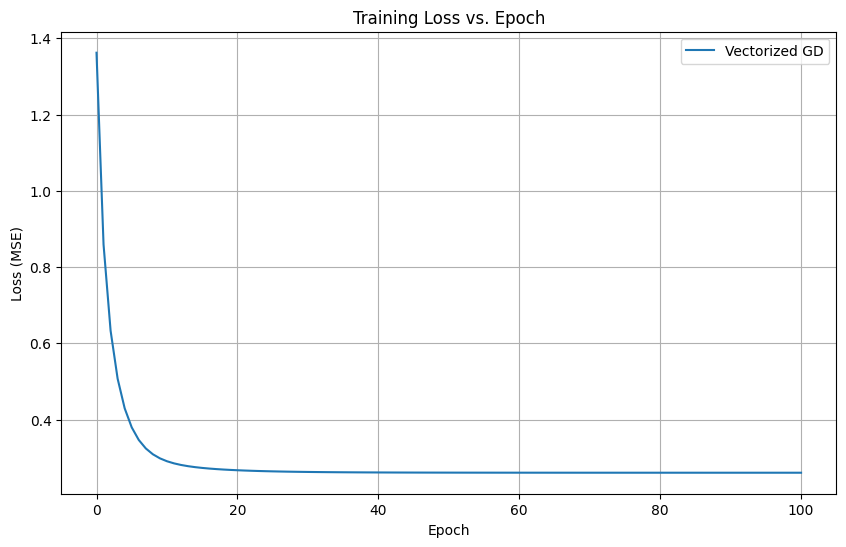

In [ ]:
from matplotlib import pyplot as plt

x = list(range(training_duration))
y_v = lr_vec.loss_history

plt.figure(figsize=(10, 6))
plt.plot(x, y_v, label="Vectorized GD")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training Loss vs. Epoch")
plt.legend()
plt.grid()
plt.show()

Now we will plot the predicted values vs the actual values for our validation and test sets (usually we would use the validation set to adjust model hyperparameters, but as all models seem to converge to the same loss, this seems excessive for this simple application).

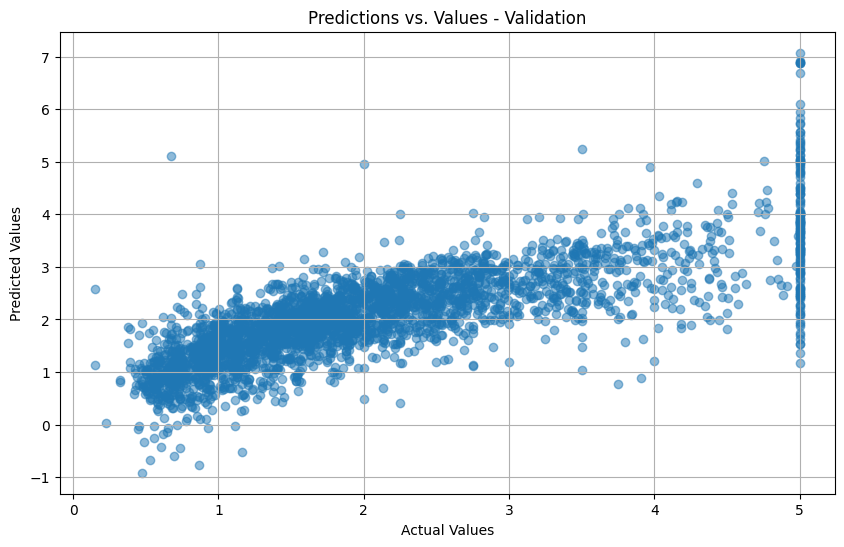

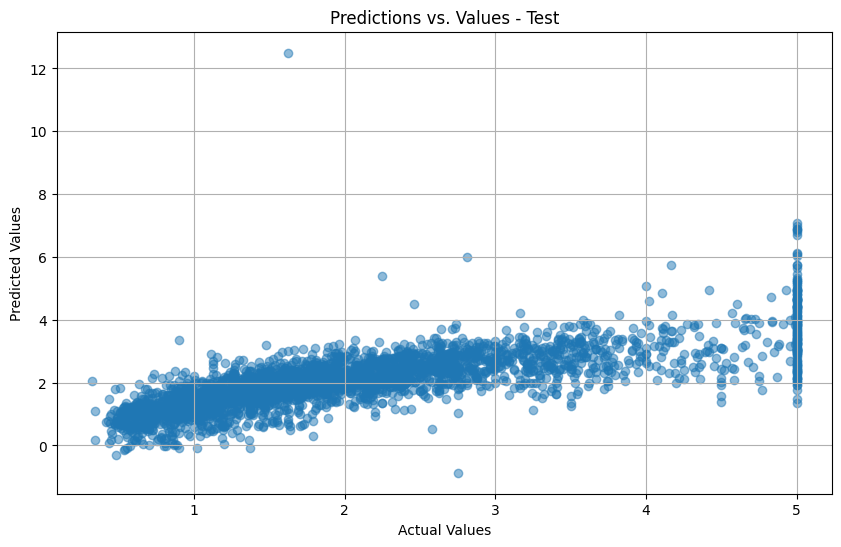

In [ ]:
# Get predictions
val_predictions = lr_vec.predict(X_val)
test_predictions = lr_vec.predict(X_test)

# Validation set
plt.figure(figsize=(10, 6))
plt.scatter(y_val, val_predictions, alpha=0.5)
plt.title("Predictions vs. Values - Validation")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid()

# Test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.title("Predictions vs. Values - Test")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid()

Lastly, let's calculate the MSE for our validation and test sets and compare it between our non-vectorized and our vectorized approach

In [ ]:
# Function for mse
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

# Get predictions for non-vectorized approach
y_val_pred = []
for i in range(len(y_val)):
    y_val_pred.append(lr_non_vec.predict(X_val[i, :]))

y_test_pred = []
for i in range(len(y_test)):
    y_test_pred.append(lr_non_vec.predict(X_test[i, :]))

# Calculate mse
nv_mse_val = mse(y_val, y_val_pred)
nv_mse_test = mse(y_test, y_test_pred)

v_mse_val = mse(y_val, val_predictions)
v_mse_test = mse(y_test, test_predictions)

# Compare mse
print(f"Validation MSE (Non-Vectorized GD): {round(nv_mse_val, 4)}")
print(f"Validation MSE (Vectorized GD): {round(v_mse_val, 4)}")
print(f"Difference: {nv_mse_val - v_mse_val}")
print("-------------------------------------")
print(f"Test MSE (Non-Vectorized GD): {round(nv_mse_test, 4)}")
print(f"Test MSE (Vectorized GD): {round(v_mse_test, 4)}")
print(f"Difference: {nv_mse_test - v_mse_test}")

NameError: name 'val_predictions' is not defined

It seems that both models converge to similar parameters which makes sense because we show them the same training data in the same order. 